## 1. Load and Normalize `CIFAR10`

In computer-vision, CIFAR-10  is an established benchmark dataset used object recognition. It is a subset of 80 million tiny images. CIFAR-10 consists of $60,000$ $32\times32$ color images containing objects of one of 10 classes (with 6000 images per class). It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The classes represented in the dataset are:

* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms

### Image Augumentation
- We have to do this job before making our model. The expectation that augmentation will prevent overfitting. This is not guaranteed and at the current stage in the class where we have not covered the topic is a dirty hack. Please treat it as such. namely - an artificial way to increase training data without relying on the unknown data generation process.

To additionally reduce the chance of overfitting, let's carry out Normalization and Regularization as below

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

In [7]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
trainloader =torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


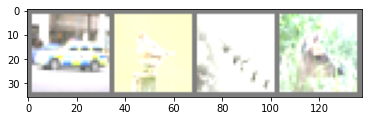

  car  bird plane  deer


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 2. Define a Convolution Neural Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a loss function and optimizer

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4.Train the Network 

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.169
[1,  4000] loss: 1.861
[1,  6000] loss: 1.706
[1,  8000] loss: 1.614
[1, 10000] loss: 1.572
[1, 12000] loss: 1.503
[2,  2000] loss: 1.456
[2,  4000] loss: 1.445
[2,  6000] loss: 1.422
[2,  8000] loss: 1.398
[2, 10000] loss: 1.401
[2, 12000] loss: 1.392


#### Saving our `model` 

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the Network on the test data

After training the network for 2 passes over the training dataset 
We will now predict the class label that the neural network outputs to check 
if the network has learnt anything. 
Now, displaying the images from the test data

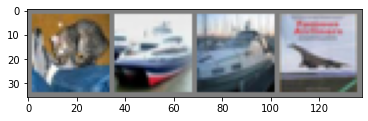

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

What NN thinks of the above images

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   car  ship plane


#### Performance of the model on the `whole dataset`

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

#### Checking the particular class performance 

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 65.5 %
Accuracy for class car   is: 82.4 %
Accuracy for class bird  is: 48.8 %
Accuracy for class cat   is: 35.3 %
Accuracy for class deer  is: 53.6 %
Accuracy for class dog   is: 41.0 %
Accuracy for class frog  is: 77.2 %
Accuracy for class horse is: 75.2 %
Accuracy for class ship  is: 72.6 %
Accuracy for class truck is: 63.8 %
